# BRUN0-NET

La competizione che abbiamo scelto di affrontare richiede di creare un modello che è capace di assegnare automaticamente una valutazione ad un possibile testo che gli verrebbe sottoposto da uno studente, a partire dalle medie, fino all'ultimo anno di superiori.

La nota cruciale del sistema è che deve valutare testi di tipo argomentativo, esprimendo quindi una valutazione su componenti come l'organizzazione, le prove a supporto di una tesi, lo sviluppo delle idee, e altro, mantenendo però un costo ridotto per permettere anche a comunità meno abbienti di usufruirne.

Lo sviluppo del progetto è stato portato avanti utilizzando `keras` e `BERT` per quanto riguarda la parte di Machine Learning, e varie librerie di Python per il resto. Il codice è interamente scritto in Python.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import matplotlib.ticker as mtick
from IPython.display import display, Markdown
import re

SEED = 118
dataset_path = "./dataset"
bert_path = f"{dataset_path}/bert"

# imposta il random seed per Python, Numpy and TensorFlow (OMG AMAZING 😲)
tf.keras.utils.set_random_seed(SEED)

## Analisi del Dataset

Il dataset fornito da keras presenta circa 3000 testi argomentativi di studenti statunitensi che variano in livello da medie a superiori.
Ogni testo è stato analizzato da esperti per estrapolarne elementi del discorso comunemente trovati in testi argomentativi, in paricolare:

- `Lead`: ovvero un'introduzione che serve per catturare l'attenzione del lettore e indirizzarlo verso la tesi
- `Position`: un'opinione o conclusioni tratte sull'argomento portato
- `Claim`: un'affermazione che supporti la posizione
- `Counterclaim`: un'affermazione che confuta un'altra affermazione o fornisce una motivazione contraria alla posizione
- `Rebuttal`: una nuova affermazione che confuta la `Counterclaim`
- `Evidence`: idee a supporto della `Claim`
- `Concluding Statement`: una frase conclusiva che ribadisce le affermazioni


Ogniuna di queste componenti è affiancata ad uno di tre giudizi che saranno le nostre label per la fase di training:

- `Ineffective`
- `Adequate`
- `Effective`


Carico il dataset in memoria e ne stampo una breve anteprima

In [2]:
dataset = pd.read_csv(f'{dataset_path}/train.csv')
dataset.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


Controllo quanti `essey_id` compaiono nel dataset e quanti ne ho nella cartella `train`

In [3]:
unique_esseyid_dataset = dataset["essay_id"].unique()
esseyid_number = len(unique_esseyid_dataset)

real_esseyid_number = !ls {dataset_path}/train | wc -l

print(f"N Essey ID in dataset: {esseyid_number}")
print(f"N Essey ID in folder:  {real_esseyid_number[0]}")

N Essey ID in dataset: 4191
N Essey ID in folder:  4191


Vado a stampare la frequenza dei vari elementi delle colonne `discourse_type` e `discourse_effectiveness` per vedere quanto il dataset è sbilanciato

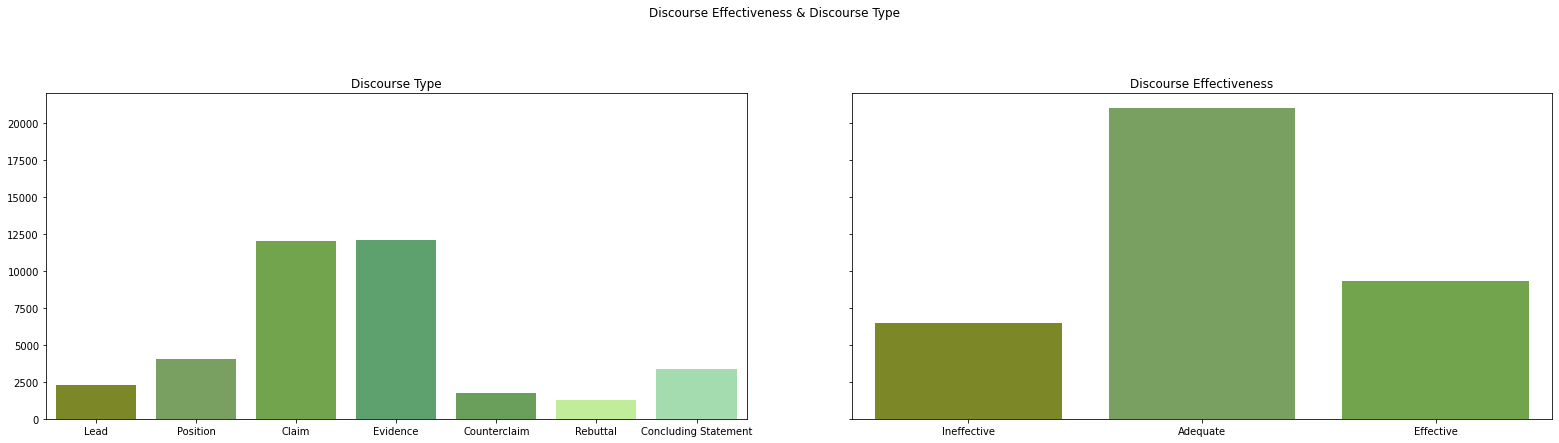

In [4]:
palette = ["xkcd:baby shit green", "xkcd:asparagus", "xkcd:nasty green", "xkcd:algae", "xkcd:fern", "xkcd:pistachio", "xkcd:hospital green"]

fig, axes = plt.subplots(1, 2, figsize=(27, 6), sharey='row')

# discoruse type
labels = dataset['discourse_type'].unique()
sns.countplot(
    x="discourse_type", 
    data=dataset, 
    linewidth=1.25, 
    alpha=1, 
    ax=axes[0], 
    zorder=2, 
    order=labels, 
    palette=palette
)
axes[0].set(xlabel=None, ylabel=None, title="Discourse Type")

# discoruse effectiveness
labels = ["Ineffective", "Adequate", "Effective"]
sns.countplot(
    x="discourse_effectiveness", 
    data=dataset, 
    linewidth=1.25, 
    alpha=1, 
    ax=axes[1], 
    zorder=2, 
    order=labels, 
    palette=palette
)
axes[1].set(xlabel=None, ylabel=None, title="Discourse Effectiveness")

fig.suptitle('Discourse Effectiveness & Discourse Type', y=1.08)
fig.subplots_adjust(
    wspace=0.15, 
    #left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.4
)

plt.show()

Vado a stampare, per ogni tipologia di testo, quanti di questi risultano `Adequate`, `Effective` e `Ineffective`.

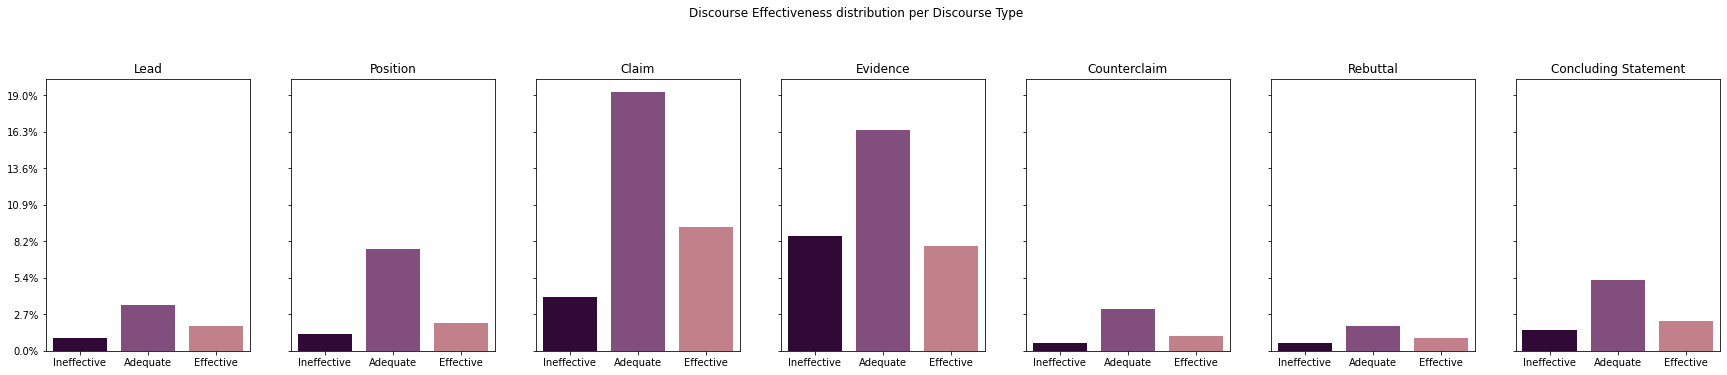

In [5]:
palette = ["xkcd:deep purple", "xkcd:light eggplant", "xkcd:ugly pink"]

discourse_types = dataset.discourse_type.unique()
discourse_id = len(dataset.discourse_id)
fig, axes = plt.subplots(1, len(discourse_types), sharex='col', sharey='row', figsize=(30, 5))
for i, discourse_type in enumerate(discourse_types):
    ax = axes[i]
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(discourse_id))

    filtered_df = dataset[dataset.discourse_type == discourse_type]
    
    sns.countplot(
        x="discourse_effectiveness", 
        data=filtered_df, 
        linewidth=1.25, 
        alpha=1, 
        ax=ax, 
        zorder=2, 
        order=labels, 
        palette=palette
    )
    ax.set(xlabel=None, ylabel=None, title=discourse_type)

fig.suptitle('Discourse Effectiveness distribution per Discourse Type', y=1.08)
plt.show()

Possiamo notare dai precedenti grafici che il dataset risulta molto **sbilanciato**:

- Nella colonna `discourse_effectiveness`, ho tantissimi elementi che appartengono alla classe `Adequate` e pochissimi per le altre 2 classi (`Effective` e `Ineffective`)
- Nella colonna `discourse_type`, ho tantissimi testi che appartengono alle tipologia `Evidence` e `Claim` ma estremamente pochi per tutte le altre

Possiamo inoltre notare che la distribuzione **_Gaussiana_** è quella che approssima meglio quella dei nostri dati.

Proviamo ora a rimuovere le stopwords e a creare dunque due dataset differenti.


Per visualizzare le differenze tra i dataset sono riportate delle tabelle che evidenziano la diminuzione della quantità di testo e la percentuale della punteggiatura rispetto alle parole.

In [6]:
# CON STOPWORDS

chars_count = []
words_count = []
punctuation_count = []

for text in dataset["discourse_text"]:
    chars = len(text)
    punctuation = len(re.findall(r"[^\w\s ']", text))
    
    chars_count.append(chars)
    words_count.append(len(re.split(r'\b\W+\b', text)))
    punctuation_count.append(punctuation)

    
dataset["discourse_chars_count"] = pd.Series(chars_count)
dataset["discourse_words_count"] = pd.Series(words_count)
dataset["discourse_punctuation_count"] = pd.Series(punctuation_count)

series_data = []
for cls in dataset["discourse_effectiveness"].unique():
    chars_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_chars_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    words_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_words_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    punctuation_count_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_punctuation_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    punctuation_percent_mean = round(punctuation_count_mean / chars_mean * 100, 3)

    # print(f'{cls}: {chars_mean} c / {words_mean} w / {punctuation_count_mean} p / {punctuation_percent_mean} p%')
    series_data.append([chars_mean, words_mean, punctuation_count_mean, punctuation_percent_mean])

# creo un nuovo dataframe per visualizzare meglio i dati
df_stat_stops = pd.DataFrame(series_data, columns=['N. Chars', 'N. Words', 'N. Punctuation', 'Punctuation Percent (%)'], index=dataset["discourse_effectiveness"].unique().tolist())

In [7]:
# SENZA STOPWORDS
import nltk


# scarica il file stopwords se non presente
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


from nltk.corpus import stopwords

# creo la regex per individuare le stopwords
stops = set(stopwords.words("english"))
stops_regex = r""
for stop in stops:
    stops_regex += fr"\b{stop}\b|"

stops_regex = stops_regex[: -1]

no_stops = []
chars_count = []
words_count = []
punctuation_count = []

for text in dataset["discourse_text"]:
    # da forma compatta a forma estesa: i'm -> i am
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    # rimozione delle stopwords
    nostops_text = re.sub(stops_regex, '', text)

    chars = len(nostops_text)
    words = len(re.split(r'\b\W+\b', nostops_text))
    punctuation = len(re.findall(r"[^\w\s ']", nostops_text))
    
    no_stops.append(nostops_text)
    chars_count.append(chars)
    words_count.append(words)
    punctuation_count.append(punctuation)

dataset["discourse_nostops"] = pd.Series(no_stops)
dataset["discourse_chars_count"] = pd.Series(chars_count)
dataset["discourse_words_count"] = pd.Series(words_count)
dataset["discourse_punctuation_count"] = pd.Series(punctuation_count)

series_data = []
for cls in dataset["discourse_effectiveness"].unique():
    chars_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_chars_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    words_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_words_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    punctuation_count_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_punctuation_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    punctuation_percent_mean = round(punctuation_count_mean / chars_mean * 100, 3)

    series_data.append([chars_mean, words_mean, punctuation_count_mean, punctuation_percent_mean])

# creo un nuovo dataframe per visualizzare meglio i dati
df_stat_nostops = pd.DataFrame(series_data, columns=['N. Chars', 'N. Words', 'N. Punctuation', 'Punctuation Percent (%)'], index=dataset["discourse_effectiveness"].unique().tolist())

In [8]:
display(Markdown("### Statistiche CON Stopwords"))
display(df_stat_stops.head())

display(Markdown("### Statistiche SENZA Stopwords"))
display(df_stat_nostops.head())

display(Markdown("### Riduzione del testo togliendo le Stopwords"))
display(df_stat_nostops - df_stat_stops)

### Statistiche CON Stopwords

,N. Chars,N. Words,N. Punctuation,Punctuation Percent (%)
Adequate,193,36,3,1.554
Ineffective,266,49,4,1.504
Effective,364,64,6,1.648


### Statistiche SENZA Stopwords

,N. Chars,N. Words,N. Punctuation,Punctuation Percent (%)
Adequate,144,19,3,2.083
Ineffective,199,26,4,2.010
Effective,276,34,6,2.174


### Riduzione del testo togliendo le Stopwords

,N. Chars,N. Words,N. Punctuation,Punctuation Percent (%)
Adequate,-49,-17,0,0.529
Ineffective,-67,-23,0,0.506
Effective,-88,-30,0,0.526


## PreProcessing Dataset

Iniziamo la preparazione del dataset andando a convertire le classi della colonna `discourse_effectiveness` in valori univoci (`int`) per poterli poi passare al modello con più semplicità.

In [9]:
def words_to_indices(words: pd.Series) -> list:
    """
        Questa funzione va ad assegnare un ID unico (parte da 0) ad ogni elemento della serice (colonna)
        che gli viene passato.

        E.g.
            input:  pd.Series(['a', 'b', 'a', 'c', 'd', 'c'])
            output: [(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd')]
    """

    enumeration = enumerate(words.unique()) # prende ogni elemento 1 sola volta
                                            # funzione unique() fa si che ad ogni run l'ordine della parole sia lo stesso
                                            # a differenza di set()
    
    return list(enumeration)


In [10]:
# assegna degli indici univoci alle classi della colonna discourse_effectiveness
effectiveness_label_index = words_to_indices(dataset["discourse_effectiveness"])

# creo le due nuove colonne
dataset["effectiveness_label"] = dataset['discourse_effectiveness']

# rimpiazzo gli elementi dalle nuove colonne con quelli corretti (gli indici numerici)
for new_value, old_value in effectiveness_label_index:
    dataset["effectiveness_label"].replace(old_value, new_value, inplace=True)

Definiamo la configurazione base per il modello di Embedding **BERT** ed altri parametri.

In [11]:
# Bert Configuration
AUTO = tf.data.experimental.AUTOTUNE
MAX_LEN = 256
EPOCHS = 3
BATCH_SIZE = 12

Definiamo una funzione che invoca automaticamente il **tokenizer** di BERT con parametri studiati apposiatamente per la fase di encoding del nostro problema.


In [12]:
# Definizione del modello di encoding con Bert
def bert_encode(texts, tokenizer, max_len=MAX_LEN):
    input_ids      = []
    token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(
            text, 
            max_length=max_len, 
            truncation=True, 
            padding='max_length',
            add_special_tokens=True
            )
        input_ids.append(token['input_ids'])
        token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(token_type_ids), np.array(attention_mask)

In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Il token `sep` è un token speciale che ci serve per risolvere il nostro problema di NLP, in qunto permette di concatenare, però tendole distinte, due frasi.

In particolare noi concateneremo la parte del testo inerente ad una particolare parte del discorso con il suo label, consentendo al modello di comprendere la correlazione tra `discourse_type` e testo vero e proprio.


In [14]:
sep = tokenizer.sep_token
sep

'[SEP]'

Andiamo ad aggiungre una nuova colonna al dataset dove andremo a concatenare il tipo del discorso ed il discorso stesso (uniamo le colonne `discourse_type` e `discourse_text`) tramite un carattere **separatore** che BERT sarà in grado di riconoscere.

In [15]:
# genera una nuova colonna includendo 'discourse_type' all'interno del testo da analizzare
dataset['inputs'] = dataset.discourse_type + sep + dataset.discourse_text
dataset['inputs_nostops'] = dataset.discourse_type + sep + dataset.discourse_nostops
dataset.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,discourse_chars_count,discourse_words_count,discourse_punctuation_count,discourse_nostops,effectiveness_label,inputs,inputs_nostops
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,220,28,6,"Hi, Isaac, going writing face Mars...",0,"Lead[SEP]Hi, i'm Isaac, i'm going to be writin...","Lead[SEP]Hi, Isaac, going writing f..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,147,21,3,"On perspective, I think face natural land...",0,"Position[SEP]On my perspective, I think that t...","Position[SEP]On perspective, I think face ..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,67,9,0,I think face natural landform life Ma...,0,Claim[SEP]I think that the face is a natural l...,Claim[SEP]I think face natural landform ...
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,266,36,11,"If life Mars, would know . The reason I t...",0,"Evidence[SEP]If life was on Mars, we would kno...","Evidence[SEP]If life Mars, would know . Th..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,64,8,1,People thought face formed alieans thoug...,0,Counterclaim[SEP]People thought that the face ...,Counterclaim[SEP]People thought face formed...


Andiamo a suddividere il dataset, per la fase di training, in 2 sottoinsiemi:

- Training Set (80%)
- Validation Set (20%)

Lo facciamo in modo tale che parti dello stesso testo finiranno sempre insieme nello stesso set

In [16]:
from sklearn.model_selection import GroupShuffleSplit


X = dataset[["essay_id", "inputs", "inputs_nostops"]]
y= dataset["effectiveness_label"]

gs = GroupShuffleSplit(n_splits=3, test_size=.2, random_state=420)  # fa si che tutti gli elementi di un testo rimangano nello stesso set
train_ix, test_ix = next(gs.split(X, y, groups=X.essay_id))

X_train = X.loc[train_ix]
y_train = y.loc[train_ix]

X_test = X.loc[test_ix]
y_test = y.loc[test_ix]

# CON STOPWORDS
x_train = X_train["inputs"]
x_test = X_test["inputs"]

# SENZA STOPWORDS
x_train_nostops = X_train["inputs_nostops"]
x_test_nostops = X_test["inputs_nostops"]


In [17]:
print(x_train[0])
print(x_train_nostops[0])
print(y_train[0])

Lead[SEP]Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. 
Lead[SEP]Hi,    Isaac,    going   writing    face  Mars   natural landform     life  Mars  made . The story    NASA took  picture  Mars   face  seen   planet. NASA    know   landform  created  life  Mars,       natural landform. 
0


Andiamo ad applicare il tokenizer di BERT all'input per codificarlo in modo tale da essere passato al modello.

In [18]:
# CON STOPWORDS
x_train = bert_encode(x_train.astype(str), tokenizer)
x_test = bert_encode(x_test.astype(str), tokenizer)

y_train = y_train.values
y_test = y_test.values

# SENZA STOPWORDS
x_train_nostops = bert_encode(x_train_nostops.astype(str), tokenizer)
x_test_nostops = bert_encode(x_test_nostops.astype(str), tokenizer)

y_train_nostops = y_train
y_test_nostops = y_test

## Model Selection

Dopo aver preparato l'input per BERT e aver modificato il dataset rendendolo adatto al nostro task, procediamo con la creazione di svariati modelli per capire quale architettura possa prestarsi meglio al nostro problema.

Per come è costruito il nostro input dobbiamo creare i modell utilizzando il paradigma **funzionale** e non sequenziale.

In [19]:
import json
from tensorflow import keras
from keras.layers import Dense, LSTM, Dropout, Flatten, Input, MaxPooling1D, Conv1D
from keras.models import Model
from transformers import TFBertModel
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

2022-07-19 10:27:52.025642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 10:27:52.029361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 10:27:52.029520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 10:27:52.029847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Scriviamo una funzione che ci aiuta ad allenare i vari modelli e visualizzare l'esito di questa fase per ognugno.

In [20]:
def train_and_plot(model_builder: callable, model_version: str, batch_size=BATCH_SIZE, epochs=30, patience=10, steps_per_epoch=100, remove_stopwards=False):
    # pulisce la sessione di Keras permettendomi di caricare in memoria modelli in successione
    K.clear_session()
    # imposto il seed al valore iniziale per far si che tutti gli allenamenti risultino uguali
    tf.keras.utils.set_random_seed(SEED)
    
    model = model_builder()
    model.summary()

    keras.utils.plot_model(model, f"./BRUN0-Net-{model_version}.png") # salva la foto del modello

    # --- SCELTA STOPWORDS ---
    if remove_stopwards:
        train = x_train_nostops
        test = x_test_nostops
        print('no stops')
    else:
        train = x_train
        test = x_test
        print('stop')
    
    # --- DATASET ---
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(batch_size)
        .prefetch(AUTO)
    )

    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices((test, y_test))
        .batch(batch_size)
        .cache()
        .prefetch(AUTO)
    )

    # --- CALLBACKS ---
    model_filepath = f'BRUN0-Net-{model_version}.h5'

    # Early Stopping:  ferma la fase di trainign quando la val_los non migliora per {patience} epoche
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=patience
    )

    # Salva il modello su file quando migliora la val_los
    save_best = ModelCheckpoint(
        model_filepath, 
        monitor='val_loss', 
        save_best_only=True, 
        mode='min', 
        verbose=1
    ) 

    # --- TRAINING ---
    history = model.fit(
        train_dataset,
        validation_data=test_dataset, 
        epochs=epochs, 
        verbose=True, 
        steps_per_epoch=steps_per_epoch,
        callbacks=[es, save_best]
    )

    # --- HISTORY ---
    history_dict = history.history
    json.dump(history_dict, open(f'./history_save-{model_version}.bk', 'w'))

    # utile per quando serve ricaricare il file history in memoria
    # history_dict = json.load(open('./history_save.bk', 'r'))

    # --- GRAFICI ALLENAMENTO ---
    # accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Primo Allenamento

In questo allenamento abbiamo riscontrato dei problemi che portavano la Loss a non variare attraverso le epoche.
Abbiamo visto che il problema era legato al modo in cui l'optimizer veniva invocato e quindi non avveniva nessun apprendimento nei nostri modelli.

Abbiamo ideato 5 modelli, tutti differenti tra loro e, dopo averli allenati tutti, andremo a selezionare il migliore.

$\alpha$) Il primo modello è composto da _BERT_ che farà da input a 2 livelli _convolutivi_ con _MaxPooling_, seguito da un _flatten_ per passarlo a 2 leyer _dense_ con _dropout_ di 0.1 tra ogniuno, infine segue un _dense_ layer di output. La activation function è _RELU_ per gli hidden layer e _softmax_ per l'output.

$\beta$) Il modello persenta un numero maggiore di layer rispetto al primo, con rispettivamente 4 _convolutivi_ e 4 _dense_ (escluso l'output) per il resto risulta analogo ad $\alpha$.

$\gamma$) Questo modello è composto da soli layer _dense_ senza _dropout_, precisamente sono 3 layer hidden, più l'output.

$\delta$) Nel modello $\delta$ abbiamo 2 layer con _LSTM_ , un _dropout_ seguito dall'output _dense_.

$\epsilon$) L'ultimo modello è composto da 2 layer _convolutivi_ con _MaxPooling_, seguiti da 2 _LSTM_ e infine da un output _dense_.


#### Model Alpha $\alpha$

In [22]:
def alpha_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(256, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)

    flatten = Flatten()(max_pool_1)
    
    # --- CLASSIFICATORE ---
    net  = Dropout(.1, name="dropout_1")(flatten)
    net  = Dense(124, activation='relu', name="dense_1")(net)
    net  = Dropout(.1, name="dropout_2")(net)
    net  = Dense(32, activation='relu', name="dense_2")(net)

    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model


2022-07-18 09:34:23.145314: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further traini

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

2022-07-18 09:34:33.639988: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


100/100 [==============================] - ETA: 0s - loss: 1.1549 - accuracy: 0.5058
Epoch 1: val_loss improved from inf to 1.02446, saving model to BRUN0-Net-alpha.h5
100/100 [==============================] - 122s 1s/step - loss: 1.1549 - accuracy: 0.5058 - val_loss: 1.0245 - val_accuracy: 0.5716
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.9904 - accuracy: 0.5700
Epoch 2: val_loss improved from 1.02446 to 0.97389, saving model to BRUN0-Net-alpha.h5
100/100 [==============================] - 112s 1s/step - loss: 0.9904 - accuracy: 0.5700 - val_loss: 0.9739 - val_accuracy: 0.5716
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 1.0091 - accuracy: 0.5367
Epoch 3: val_loss did not improve from 0.97389
100/100 [==============================] - 111s 1s/step - loss: 1.0091 - accuracy: 0.5367 - val_loss: 0.9765 - val_accuracy: 0.5716
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 0.9661 - accuracy: 0.5867
Epoch 4: val_l

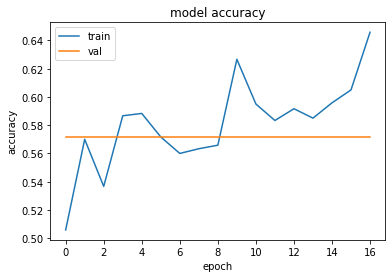

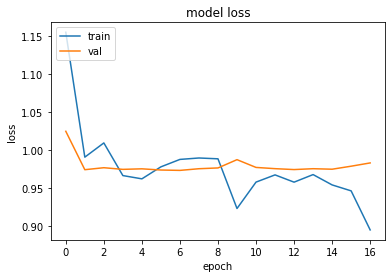

In [23]:
train_and_plot(alpha_model_builder, 'alpha')

#### Model Beta $\beta$

In [24]:
def beta_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(512, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(256, 5, activation='relu', name="conv_2")(conv_1)
    conv_3      = Conv1D(128, 5, activation='relu', name="conv_3")(conv_2)
    conv_4      = Conv1D(64, 5, activation='relu', name="conv_4")(conv_3)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_4)

    flatten = Flatten()(max_pool_1)
    
    # --- CLASSIFICATORE ---
    net  = Dropout(.2, name="dropout_1")(flatten)
    net  = Dense(126, activation='relu', name="dense_1")(net)
    net  = Dropout(.2, name="dropout_2")(net)
    net  = Dense(64, activation='relu', name="dense_2")(net)
    net  = Dropout(.1, name="dropout_3")(net)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dropout(.1, name="dropout_4")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)

    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

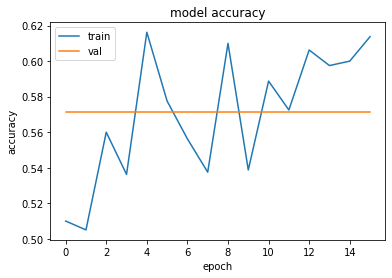

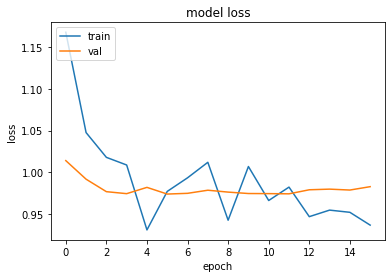

In [25]:
train_and_plot(beta_model_builder, 'beta', batch_size=8)

#### Model Gamma $\gamma$

In [26]:
def gamma_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    flatten = Flatten()(sequence_output)
    
    # --- CLASSIFICATORE ---
    # net  = Dense(126, activation='relu', name="dense_1")(flatten)
    net  = Dense(64, activation='relu', name="dense_2")(flatten)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)

    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

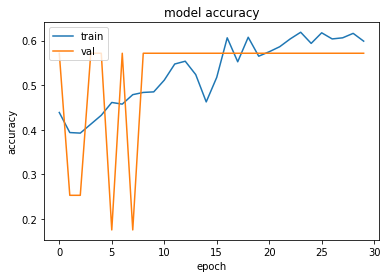

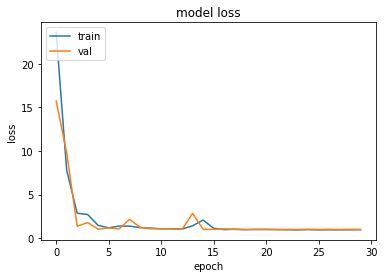

In [27]:
train_and_plot(gamma_model_builder, 'gamma', batch_size=8)

#### Model Delta $\delta$

In [28]:
def delta_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # --- MIDDEL LAYER ---
    lstm_1 = LSTM(8, return_sequences=True, name="lstm_1")(sequence_output)
    lstm_2 = LSTM(4, name="lstm_2")(lstm_1)

    # --- OUTPUT ---
    drop_out = Dropout(.1)(lstm_2)
    out = Dense(3, activation='softmax', name="output")(drop_out)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


100/100 [==============================] - ETA: 0s - loss: 1.0501 - accuracy: 0.4633
Epoch 1: val_loss improved from inf to 0.98839, saving model to BRUN0-Net-delta.h5
100/100 [==============================] - 123s 1s/step - loss: 1.0501 - accuracy: 0.4633 - val_loss: 0.9884 - val_accuracy: 0.5716
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.9906 - accuracy: 0.5675
Epoch 2: val_loss improved from 0.98839 to 0.97404, saving model to BRUN0-Net-delta.h5
100/100 [==============================] - 114s 1s/step - loss: 0.9906 - accuracy: 0.5675 - val_loss: 0.9740 - val_accuracy: 0.5716
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 1.0153 - accuracy: 0.5342
Epoch 3: val_loss did not improve from 0.97404
100/100 [==============================] - 113s 1s/step - loss: 1.0153 - accuracy: 0.5342 - val_loss: 0.9759 - val_accuracy: 0.5716
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 0.9769 - accuracy: 0.5875
Epoch 4: val_l

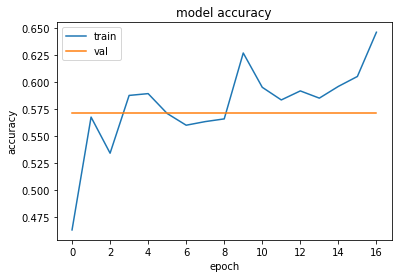

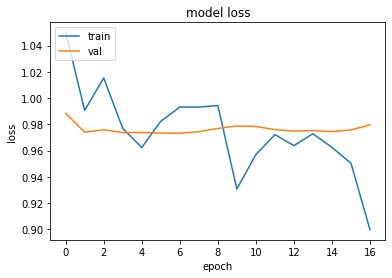

In [29]:
train_and_plot(delta_model_builder, 'delta')

#### Model Epsilon $\epsilon$

In [30]:
def epsilon_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(128, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)
    
    lstm_1 = LSTM(4, return_sequences=True, name="lstm_1")(max_pool)
    lstm_2 = LSTM(2, name="lstm_2")(lstm_1)

    # --- OUTPUT ---
    flatten = Flatten()(lstm_2)
    out = Dense(3, activation='softmax', name="output")(flatten)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

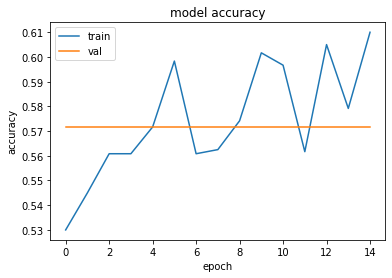

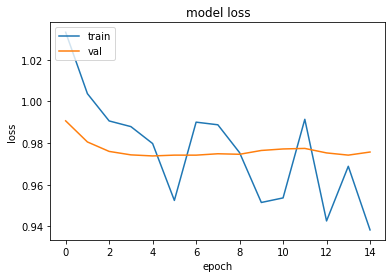

In [31]:
train_and_plot(epsilon_model_builder, 'epsilon')

### adam vs Adam vs Adam()

Procediamo ora al confronto tra le varie possibili definizioni del parametro `optimizer` della funzione `compile()` del nostro modello.
Controllando nella documentazione di `tesnorflow` i nomi degli optimizer sono scritti con la maiuscola, quindi proviamo a cambiare la stringa `adam` in `Adam` e vediamo se ciò ha effetto.

In [21]:
from keras.optimizers import Adam

In [ ]:
def Adam_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(256, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)

    flatten = Flatten()(max_pool_1)
    
    # --- CLASSIFICATORE ---
    net  = Dropout(.1, name="dropout_1")(flatten)
    net  = Dense(124, activation='relu', name="dense_1")(net)
    net  = Dropout(.1, name="dropout_2")(net)
    net  = Dense(32, activation='relu', name="dense_2")(net)

    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model


2022-07-19 08:19:47.417147: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further traini

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

2022-07-19 08:19:58.086947: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


100/100 [==============================] - ETA: 0s - loss: 1.1738 - accuracy: 0.5083
Epoch 1: val_loss improved from inf to 1.04037, saving model to BRUN0-Net-Adam_test.h5
100/100 [==============================] - 122s 1s/step - loss: 1.1738 - accuracy: 0.5083 - val_loss: 1.0404 - val_accuracy: 0.5716
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 1.0013 - accuracy: 0.5700
Epoch 2: val_loss improved from 1.04037 to 0.97623, saving model to BRUN0-Net-Adam_test.h5
100/100 [==============================] - 112s 1s/step - loss: 1.0013 - accuracy: 0.5700 - val_loss: 0.9762 - val_accuracy: 0.5716
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 1.0090 - accuracy: 0.5367
Epoch 3: val_loss did not improve from 0.97623
100/100 [==============================] - 111s 1s/step - loss: 1.0090 - accuracy: 0.5367 - val_loss: 0.9766 - val_accuracy: 0.5716
Epoch 4/5
100/100 [==============================] - ETA: 0s - loss: 0.9660 - accuracy: 0.5867
Epoch 4: 

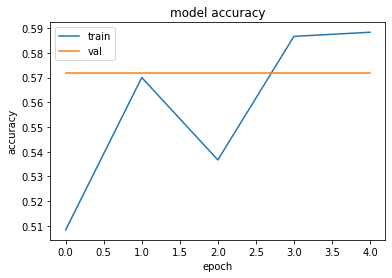

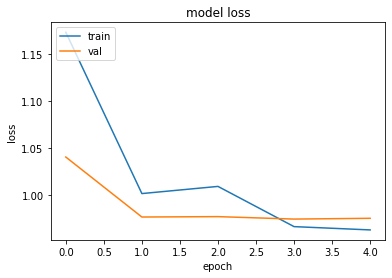

In [ ]:
train_and_plot(Adam_model_builder, 'Adam_test', epochs=5)

Anche in questo caso non cambia nulla, la `val_accuracy` rimane sempre invariata !

Proviamo ora passando l'oggetto `Adam` alla funzione `compile()` senza specificare un learning rate (utilizzando quindi quello di default).

In [22]:
def Adam_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(256, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)

    flatten = Flatten()(max_pool_1)
    
    # --- CLASSIFICATORE ---
    net  = Dropout(.1, name="dropout_1")(flatten)
    net  = Dense(124, activation='relu', name="dense_1")(net)
    net  = Dropout(.1, name="dropout_2")(net)
    net  = Dense(32, activation='relu', name="dense_2")(net)

    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model

2022-07-19 10:28:49.791409: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further traini

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

2022-07-19 10:29:00.025130: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


100/100 [==============================] - ETA: 0s - loss: 1.1598 - accuracy: 0.5075
Epoch 1: val_loss improved from inf to 1.02823, saving model to BRUN0-Net-Adam_test_obj.h5
100/100 [==============================] - 121s 1s/step - loss: 1.1598 - accuracy: 0.5075 - val_loss: 1.0282 - val_accuracy: 0.5716
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.9921 - accuracy: 0.5700
Epoch 2: val_loss improved from 1.02823 to 0.97330, saving model to BRUN0-Net-Adam_test_obj.h5
100/100 [==============================] - 113s 1s/step - loss: 0.9921 - accuracy: 0.5700 - val_loss: 0.9733 - val_accuracy: 0.5716
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 1.0081 - accuracy: 0.5367
Epoch 3: val_loss did not improve from 0.97330
100/100 [==============================] - 111s 1s/step - loss: 1.0081 - accuracy: 0.5367 - val_loss: 0.9756 - val_accuracy: 0.5716
Epoch 4/5
100/100 [==============================] - ETA: 0s - loss: 0.9668 - accuracy: 0.5867
E

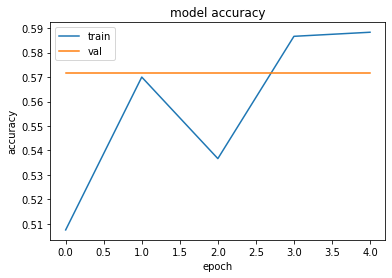

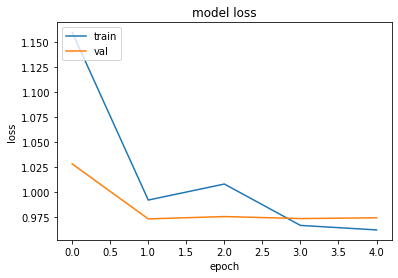

In [23]:
train_and_plot(Adam_model_builder, 'Adam_test_obj', epochs=5)

Possiamo notare che anche in questo caso non è cambiato nulla, la validation accuracy rimane sempre invariata.<br>
L'unico modo per risolvere il problema è utilizzare Adam (come oggett) e specificare un valore di learning rate differente da quello di default.
Abbiamo quindi scelto di utilizzare $\lambda = 0.00001$

### Secondo Allenamento

Dopo aver capito che l'optimizer andava invocato differentemente abbiamo testato nuovamente i nostri mdelli ottenendo una accuracy che all'incirca si situava intorno al 70%.

In [32]:
from keras.optimizers import Adam

#### Model Alpha Plus $\alpha^+$

In [24]:
def alphaplus_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(256, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)

    flatten = Flatten()(max_pool_1)
    
    # --- CLASSIFICATORE ---
    net  = Dropout(.1, name="dropout_1")(flatten)
    net  = Dense(124, activation='relu', name="dense_1")(net)
    net  = Dropout(.1, name="dropout_2")(net)
    net  = Dense(32, activation='relu', name="dense_2")(net)

    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

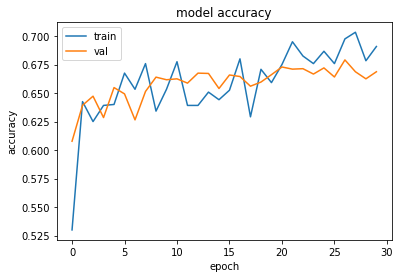

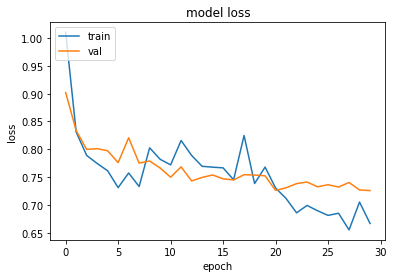

In [34]:
train_and_plot(alphaplus_model_builder, 'alpha_plus')

#### Model Beta Plus $\beta^+$

In [35]:
def betaplus_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(512, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(256, 5, activation='relu', name="conv_2")(conv_1)
    conv_3      = Conv1D(128, 5, activation='relu', name="conv_3")(conv_2)
    conv_4      = Conv1D(64, 5, activation='relu', name="conv_4")(conv_3)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_4)

    flatten = Flatten()(max_pool_1)
    
    # --- CLASSIFIER ---
    net  = Dropout(.2, name="dropout_1")(flatten)
    net  = Dense(126, activation='relu', name="dense_1")(net)
    net  = Dropout(.2, name="dropout_2")(net)
    net  = Dense(64, activation='relu', name="dense_2")(net)
    net  = Dropout(.1, name="dropout_3")(net)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dropout(.1, name="dropout_4")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)
    
    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

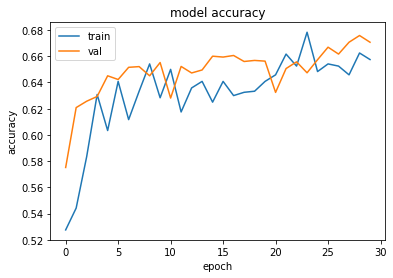

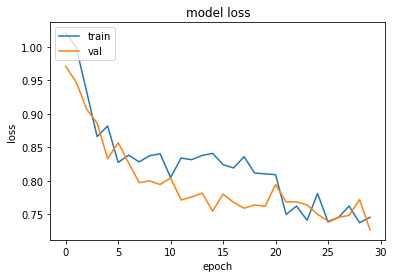

In [36]:
train_and_plot(betaplus_model_builder, 'beta_plus')

#### Model Gamma Plus $\gamma^+$

In [37]:
def gammaplus_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    flatten = Flatten()(sequence_output)
    
    # --- CLASSIFIER ---
    # net  = Dense(126, activation='relu', name="dense_1")(flatten)
    net  = Dense(64, activation='relu', name="dense_2")(flatten)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)

    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

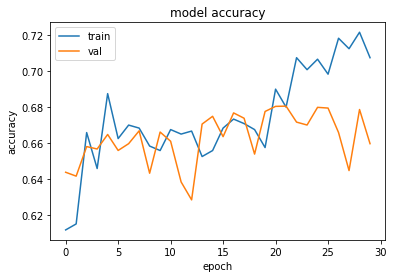

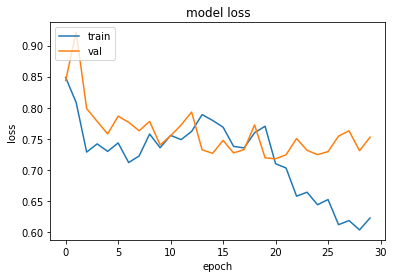

In [38]:
train_and_plot(gammaplus_model_builder, 'gamma_plus')

#### Model Delta Plus $\delta^+$

In [39]:
def deltaplus_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # --- MIDDEL LAYER ---
    lstm_1 = LSTM(8, return_sequences=True, name="lstm_1")(sequence_output)
    lstm_2 = LSTM(4, name="lstm_2")(lstm_1)

    # --- OUTPUT ---
    drop_out = Dropout(.1)(lstm_2)
    out = Dense(3, activation='softmax', name="output")(drop_out)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

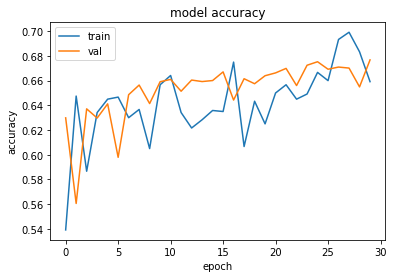

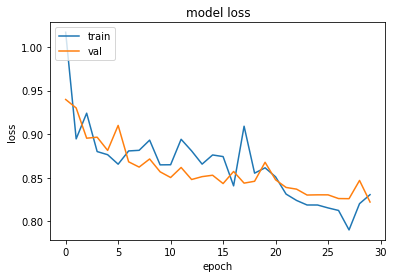

In [40]:
train_and_plot(deltaplus_model_builder, 'delta_plus')

#### Model Epsilon Plus $\epsilon^+$

In [41]:
def epsilonplus_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(128, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)
    
    lstm_1 = LSTM(4, return_sequences=True, name="lstm_1")(max_pool)
    lstm_2 = LSTM(2, name="lstm_2")(lstm_1)

    # --- OUTPUT ---
    flatten = Flatten()(lstm_2)
    out = Dense(3, activation='softmax', name="output")(flatten)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

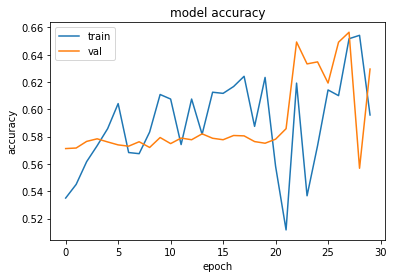

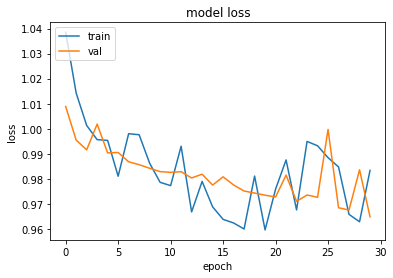

In [42]:
train_and_plot(epsilonplus_model_builder, 'epsilon_plus')

## The Best

In [29]:
from os import walk, path
from IPython.display import Image

models_dir = "./models"

In [27]:
models_dirs = []

for root, dirs, _ in walk(models_dir, topdown=True):
    for dir in dirs:
        models_dirs.append(path.join(root, dir))

print(models_dirs)

models = []
for dir in models_dirs:
    tmp_dict = {"name": dir.split('/')[-1], "model": "", "history": "", "pic": ""}
    for root, _, files in walk(dir):
        for file in files:
            name, ext = file.split('.')

            if ext == "h5":
                pass
                # tmp_dict["model"] = keras.models.load_model(path.join(root, file))
            elif ext == "png":
                tmp_dict["pic"] = Image(filename=path.join(root, file)) 
            elif ext == "bk":
                tmp_dict["history"] = json.load(open(path.join(root, file), 'r'))
                

    models.append(tmp_dict)

['./models/alpha', './models/alpha_plus', './models/beta', './models/beta_plus', './models/delta', './models/delta_plus', './models/epsilon', './models/epsilon_plus', './models/gamma', './models/gamma_plus']


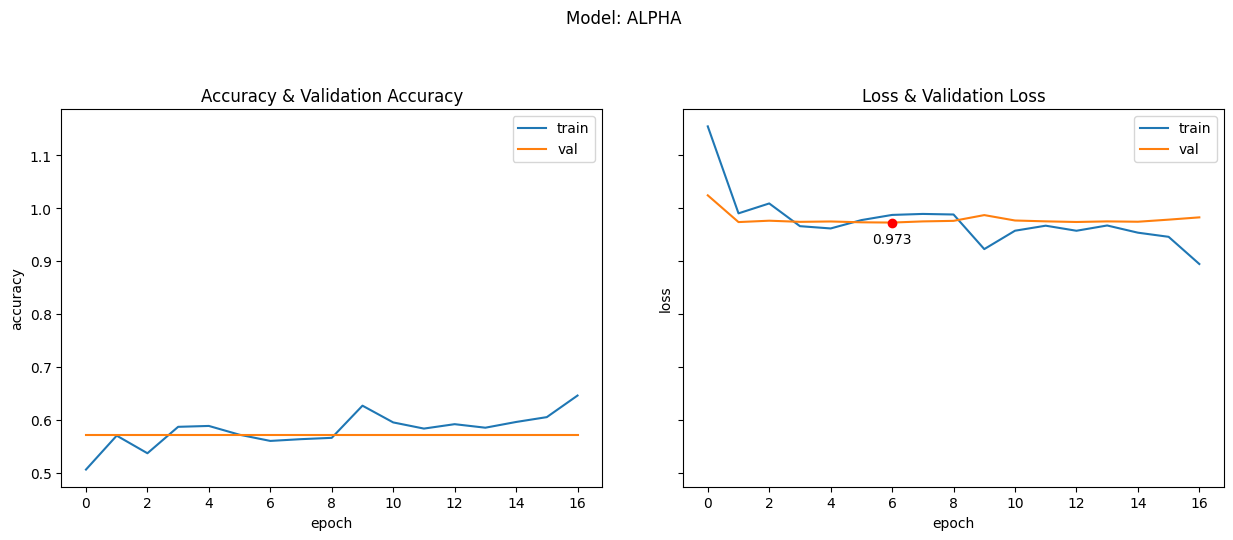

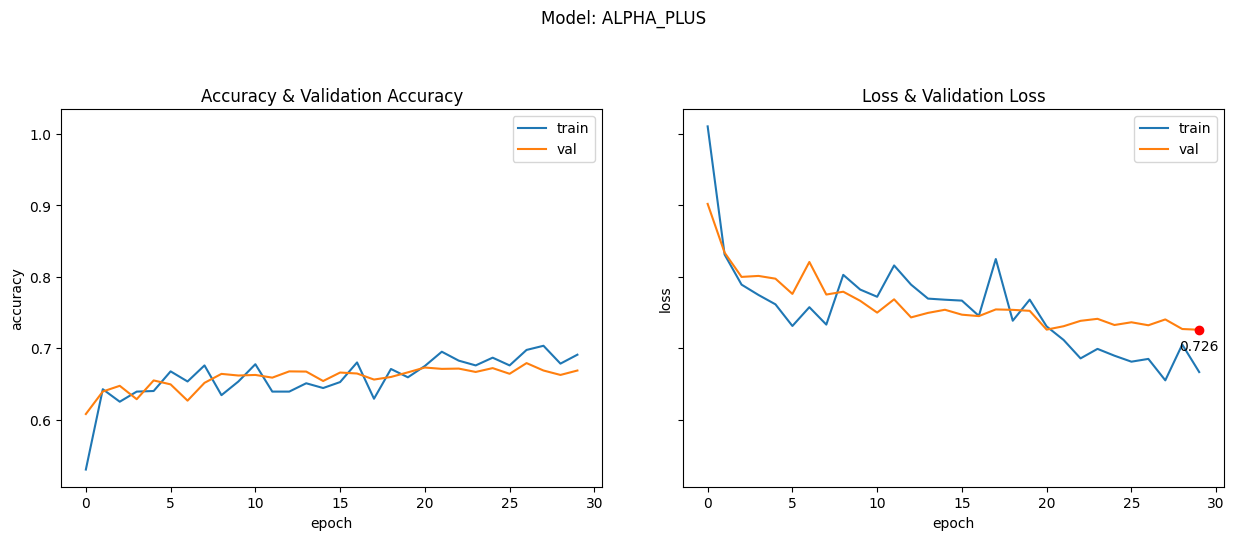

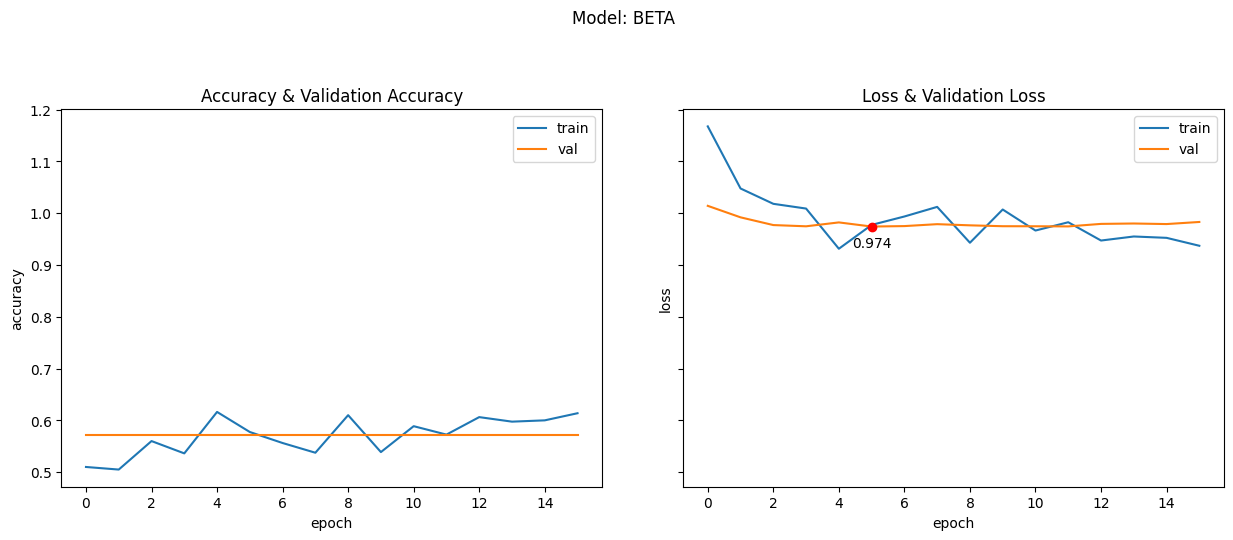

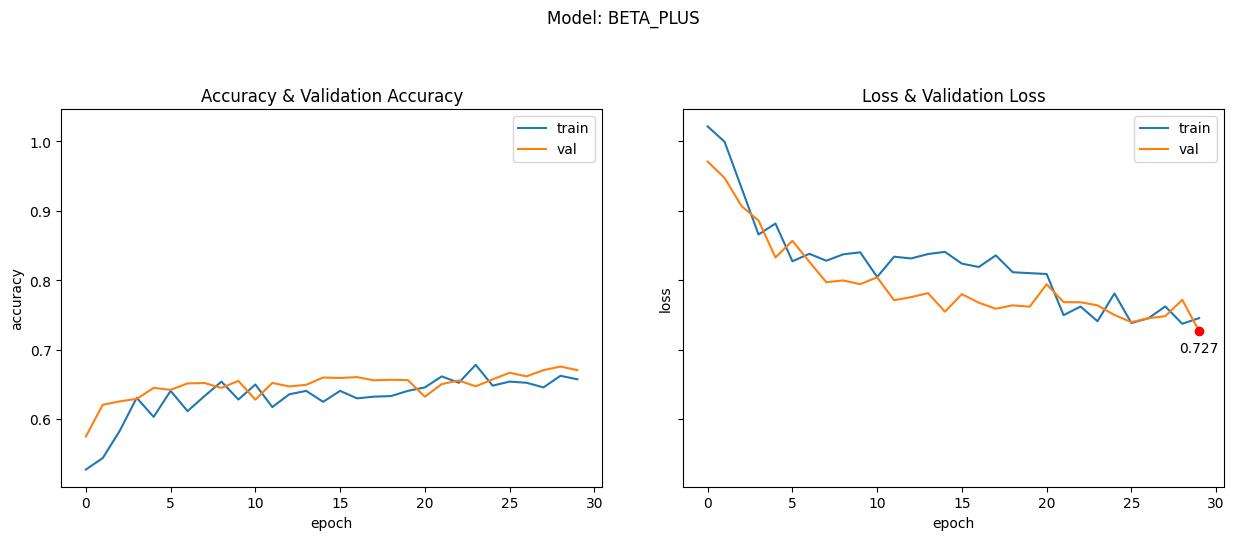

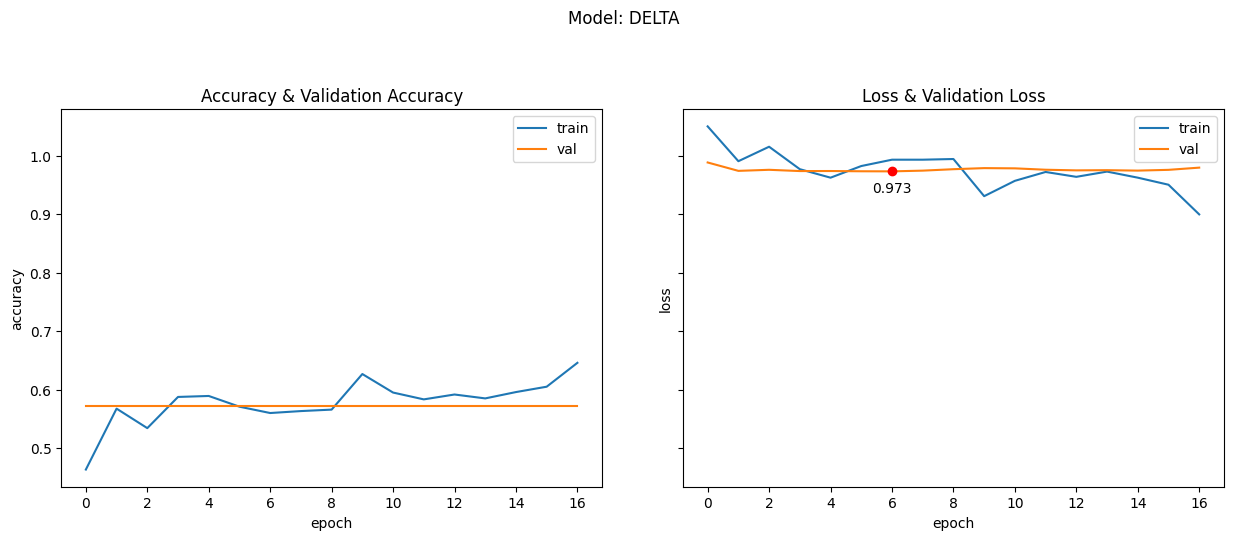

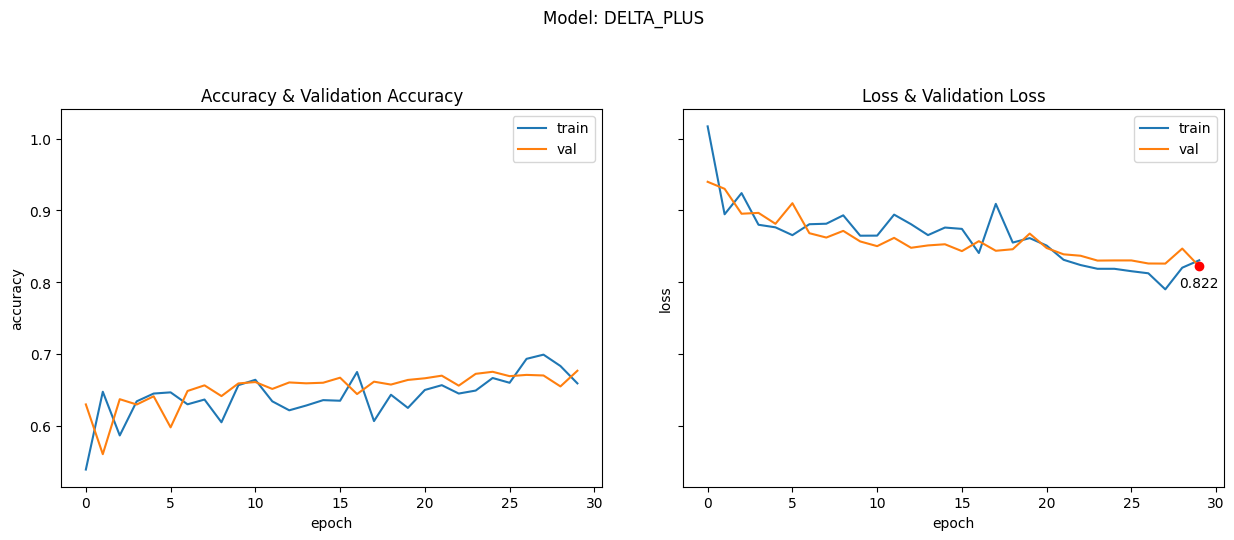

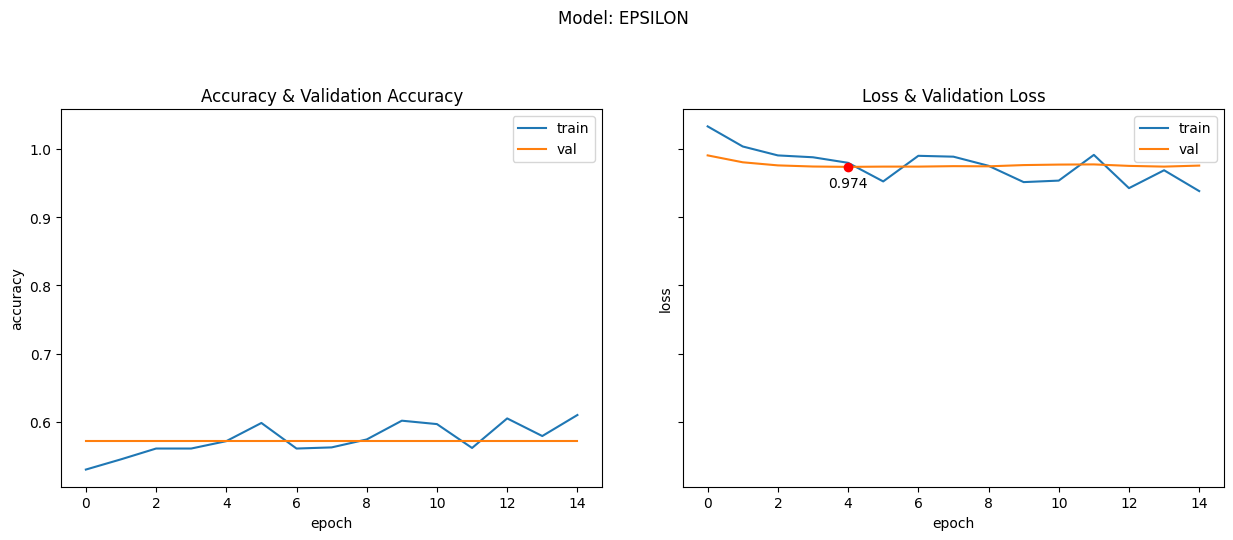

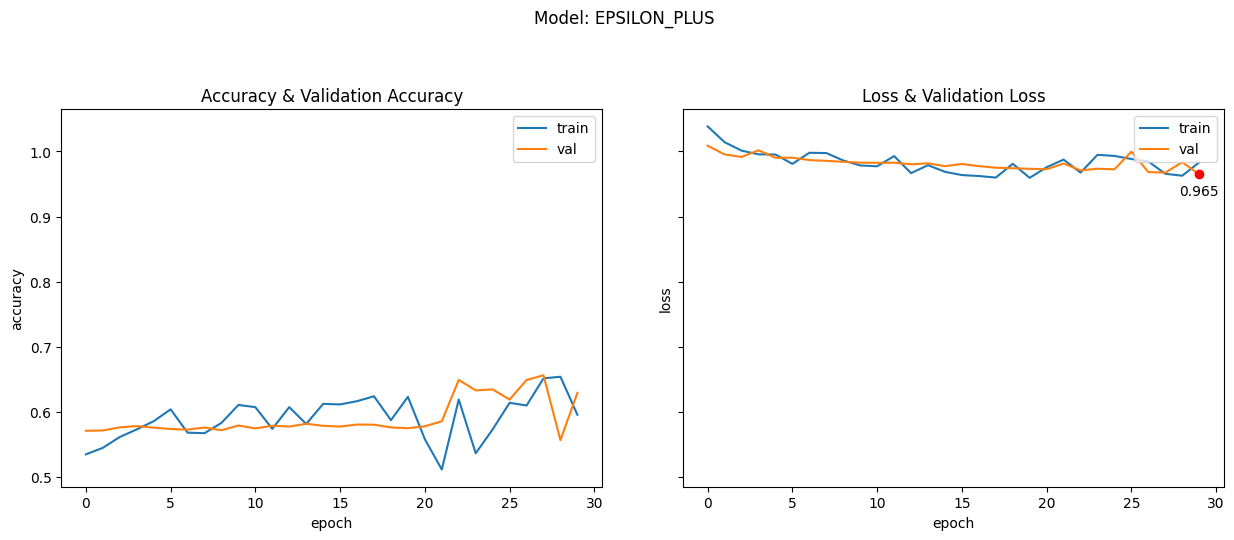

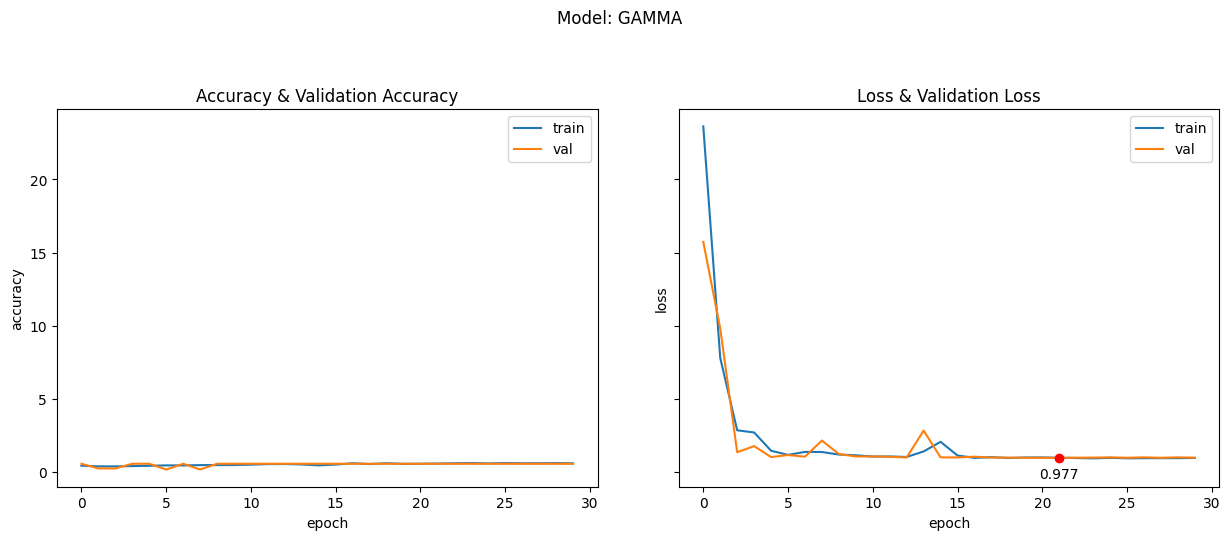

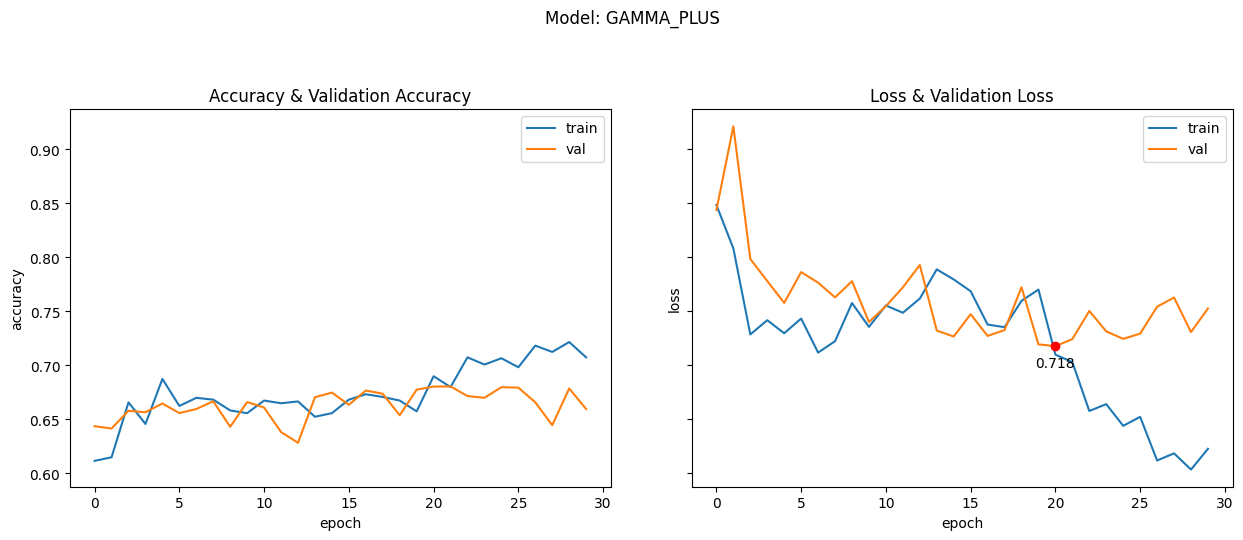

In [61]:
from cProfile import label


for model in models:
    history = model["history"]

    if history is None or history == '': continue
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row', dpi=100)

    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set(xlabel='epoch', ylabel='accuracy', title="Accuracy & Validation Accuracy")
    axes[0].legend(['train', 'val'], loc='upper right')

    # individuo il valore minimo della val_loss
    x_best_val_loss = np.argmin(history['val_loss'])
    y_best_val_loss = history['val_loss'][x_best_val_loss]

    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])

    # stampo il valore minimo della val_loss
    axes[1].plot(x_best_val_loss, y_best_val_loss, 'ro')    # ro che porta bene
    axes[1].annotate(f"{y_best_val_loss:.3f}", (x_best_val_loss, y_best_val_loss), textcoords="offset points", xytext=(0,-15), ha="center") # stampa valore al punto

    axes[1].set(xlabel='epoch', ylabel='loss', title="Loss & Validation Loss")
    axes[1].legend(['train', 'val'], loc='upper right')
    
    fig.suptitle(f'Model: {model["name"].upper()}', y=1.08)
    fig.subplots_adjust(
        wspace=0.15, 
        #left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.4
    )

    plt.show()

Il modello migliore è $\alpha^+$

## Stopwords Con o Senza ?

Proviamo a vedere se la presenza/assenza delle stopwrods va a migliorare le performance del modello.<br>
Scegliamo $\alpha^+$ come modello base dato che è risultato essere il migliore dai test effettuati in precedenza.<br>
Andremo a riallenare il modello, per 10 epoche, con il dataset che presenta le stopwords e successivamente, con quello che NON ha le stopwords. Ci aspettiamo che questa cosa non dovrebbe influenzare di tanto l'allenamento in quanto BERT è in grado di gestire autonomamente le stopwords.

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

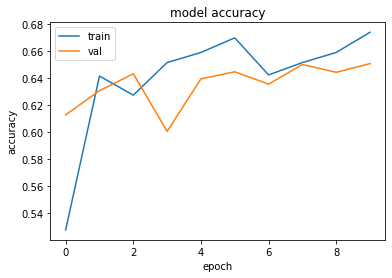

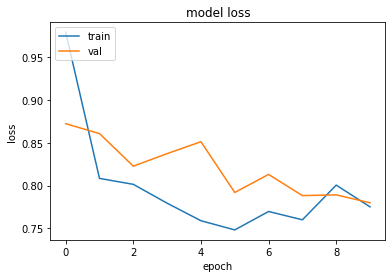

In [25]:
train_and_plot(alphaplus_model_builder, 'alpha_plus_nostops', epochs=10, remove_stopwards=True)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

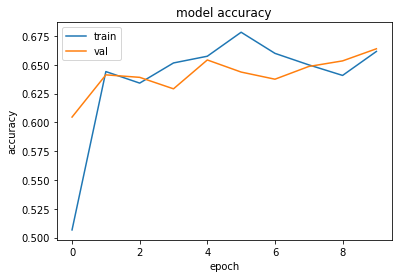

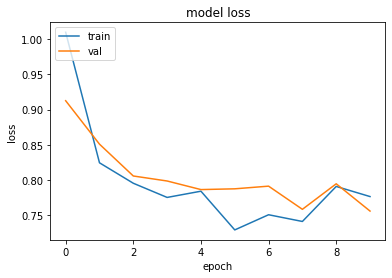

In [26]:
train_and_plot(alphaplus_model_builder, 'alpha_plus_stops', epochs=10, remove_stopwards=False)

## Training Modello $\alpha^+$

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

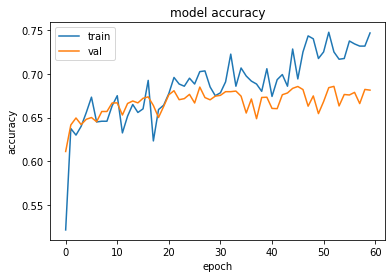

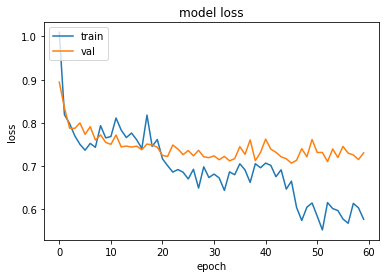

In [27]:
train_and_plot(alphaplus_model_builder, 'alpha_plus_60', epochs=60, patience=20)

Stampiamo il risultato in modo più leggibile

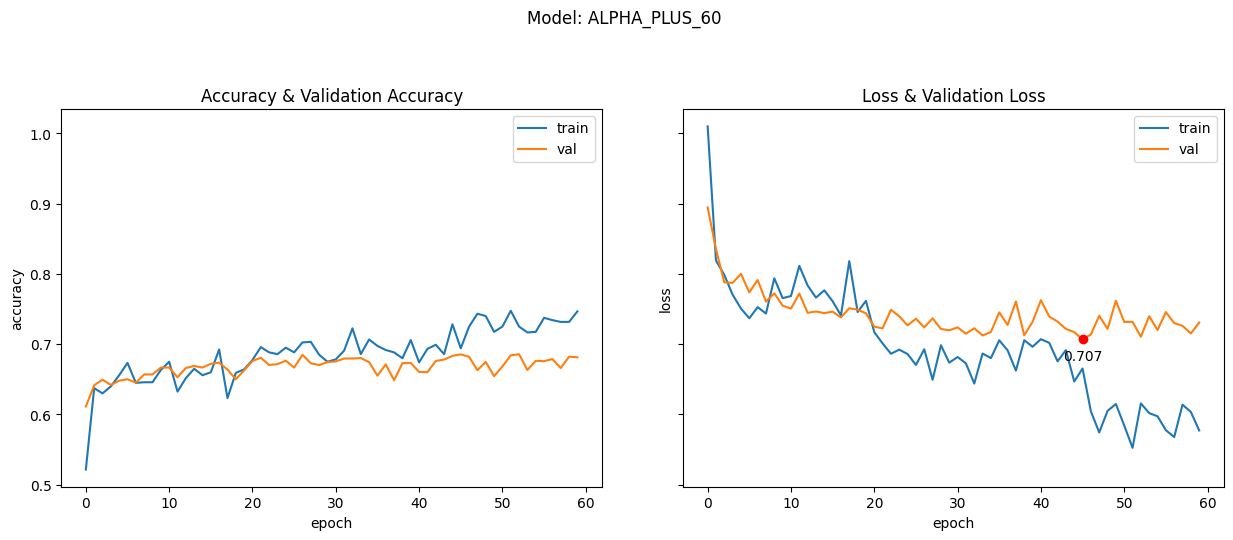

In [32]:
history_alphaplus60_file = "./models/alpha_plus_60/history_save-alpha_plus_60.bk"

history = json.load(open(history_alphaplus60_file, 'r'))

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row', dpi=100)

axes[0].plot(history['accuracy'])
axes[0].plot(history['val_accuracy'])
axes[0].set(xlabel='epoch', ylabel='accuracy', title="Accuracy & Validation Accuracy")
axes[0].legend(['train', 'val'], loc='upper right')

# individuo il valore minimo della val_loss
x_best_val_loss = np.argmin(history['val_loss'])
y_best_val_loss = history['val_loss'][x_best_val_loss]

axes[1].plot(history['loss'])
axes[1].plot(history['val_loss'])

# stampo il valore minimo della val_loss
axes[1].plot(x_best_val_loss, y_best_val_loss, 'ro')    # ro che porta bene
axes[1].annotate(f"{y_best_val_loss:.3f}", (x_best_val_loss, y_best_val_loss), textcoords="offset points", xytext=(0,-15), ha="center") # stampa valore al punto

axes[1].set(xlabel='epoch', ylabel='loss', title="Loss & Validation Loss")
axes[1].legend(['train', 'val'], loc='upper right')

fig.suptitle(f'Model: {model["name"].upper()}', y=1.08)
fig.subplots_adjust(
    wspace=0.15, 
    #left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.4
)

plt.show()